# Tutorial 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Sparse/Dense Word embeddings, Neural Networks, Training practices, Transformers

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

## PART I ($\sim$25 mins)
*   Building a **vocabulary**.
*   Building a **word-word co-occurrence matrix**.
*   Defining a **similarity metric**: cosine similarity.
*   Embedding **visualization** and **analysis** of their semantic properties.

## PART II ($\sim$25 mins)

*   Loading pre-trained **dense** word embeddings: Word2Vec, GloVe, FastText.
*   Checking **out-of-vocabulary** (OOV) terms.
*   **Handling** OOV terms.

## PART III ($\sim$25 mins)
*   Problem setting: **sentiment analysis task**.
*   Setting up a **data pipeline**: from dataset loading to data conversion.
*   **Model definition** (with Keras framework).
*   Model training, inference and **evaluation**.

## PART IV ($\sim$25 mins)

*   **Regularization** techniques: L2, Dropout, Early Stopping.
*   **Good practices** for experimenting.
*   Intro to **transformers**.

## Preliminaries

First of all, we need to import some useful packages that we will use during this hands-on session.

In [38]:
# system packages
import os
import shutil
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

### 1.1 Prepare a dataset for experiments

We will use the IMDB dataset of previous tutorial.

* [**Stats**] A dataset of 50k sentences used for sentiment analysis: 25k with positive sentiment, 25k with negative one.
* [**Temporary**] We ignore sentiment labels since we focus on learning a proper word embedding representation.

We start by **downloading** the dataset and **extract** it to a folder.

In [39]:
from urllib import request
import tarfile

print(f"Current work directory: {os.getcwd()}")
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = os.path.join(dataset_folder, "Movies.tar.gz")
print(dataset_path)

def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset(download_path: str, extract_path: str):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")


download_dataset(dataset_path, url)
extract_dataset(dataset_path, dataset_folder)

Current work directory: /mnt/hdd2/Repositories/NLP-Tutorials/2022-2023
/mnt/hdd2/Repositories/NLP-Tutorials/2022-2023/Datasets/Movies.tar.gz
Extracting dataset... (it may take a while...)
Extraction completed!


#### Data Inspection

Feel free to check the dataset folder content!

Usually, the README file is a good starting point (if it exists and it is informative -- which is not so common!).

#### Data Format

Just like in the first assignment, we need a **high level view** of the dataset that is helpful to our needs. 

We encode the dataset into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [40]:
def encode_dataset(dataset_name: str) -> pd.DataFrame:
    dataframe_rows = []
    for split in tqdm(['train', 'test']):
        for sentiment in ['pos', 'neg']:
            folder = os.path.join(os.getcwd(), "Datasets", dataset_name, split, sentiment)
            for filename in os.listdir(folder):
                file_path = os.path.join(folder, filename)
                try:
                    if os.path.isfile(file_path):
                        with open(file_path, mode='r', encoding='utf-8') as text_file:
                            # read it and extract 
                            text = text_file.read()
                            score = filename.split("_")[1].split(".")[0]
                            file_id = filename.split("_")[0]
                            num_sentiment = -1
                            if sentiment == "pos" : num_sentiment = 1
                            elif sentiment == "neg" : num_sentiment = 0

                            # create single dataframe row
                            dataframe_row = {
                                "file_id": file_id,
                                "score": score,
                                "sentiment": num_sentiment,
                                "split": split,
                                "text": text
                            }
                            dataframe_rows.append(dataframe_row)
                except Exception as e:
                    print('Failed to process %s. Reason: %s' % (file_path, e))
                    sys.exit(0)

    folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
    if not os.path.exists(folder):
        os.makedirs(folder)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["file_id", "score", "sentiment", "split", "text"]]
    dataframe_path = os.path.join(folder, dataset_name + ".pkl")
    df.to_pickle(dataframe_path)
    return df

In [41]:
print("Encoding dataset...")
df = encode_dataset(dataset_name='aclImdb')
print("Encoding completed!")

  0%|          | 0/2 [00:00<?, ?it/s]

Encoding dataset...


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Encoding completed!


Let's inspect some major details of the dataset as follows.

In [42]:
print(f"Dataset size: {df.shape}") # (50000, 5)
print(f"Dataset columns: {df.columns.values}") # ['file_id', 'score', 'sentiment', 'split', 'text]
print(f"Classes distribution:\n{df.sentiment.value_counts()}") # [0: 25000, 1: 25000]
print(f"Some examples: {df.iloc[:5]}")

Dataset size: (50000, 5)
Dataset columns: ['file_id' 'score' 'sentiment' 'split' 'text']
Classes distribution:
1    25000
0    25000
Name: sentiment, dtype: int64
Some examples:   file_id score  sentiment  split  \
0    8966    10          1  train   
1     218     9          1  train   
2    2585     7          1  train   
3   12079     7          1  train   
4    7901     7          1  train   

                                                text  
0  this is a wonderful film, makes the 1950'S loo...  
1  Taking over roles that Jack Albertson and Sam ...  
2  Here's a rare gem for those of you that haven'...  
3  For those who think of Dame May Witty as the k...  
4  Worst movie of all time? Wow, whoa now. You ca...  


# PART I
*   Building a **vocabulary**.
*   Building a **word-word co-occurrence matrix**.
*   Defining a **similarity metric**: cosine similarity.
*   Embedding **visualization** and **analysis** of their semantic properties.

## 1. Building a vocabulary

We consider words as the atomic units for text representation: each word will be associated with a numeric representation.

At this point we can build the word vocabulary of our dataset. This information is the first step of any word embedding method: we need to know the set of atomic entities that build up our corpus.

**Definition**: a vocabulary is a collection of words occurring in a given dataset. More precisely, each word is recognized and assigned to an index.

**Example**: Suppose you have the given toy corpus $D$: { "the cat is on the table" }

As you notice, the dataset is comprised of only one sentence: "the cat is on the table". The corresponding vocabulary (a possible one) will be:

V = {0: 'the', 1: 'cat', 2: 'is', 3: 'on', 4: 'table'}

In this case, indexing follows word order, but it is not mandatory!

### Note 1
The most important thing to remember is that the vocabulary should always be the same one. <br>
$\rightarrow$ Thus, make sure that the vocabulary creation routine always returns the same result!

### Note 2
A vocabulary is exclusively defined by the tokenization step you define! <br>
$\rightarrow$ Characters, sub-words, words are examples of granularity levels.

### 1.1 Text pre-processing

Before vocabulary creation, we have to do a little bit of **text pre-processing** so as to avoid spurious data. <br>
$\rightarrow$ Data quality is one of the crucial factors that lead to better performance. <br>
$\rightarrow$ Models, even state-of-the-art ones, hardly achieve satisfying results if the dataset is very noisy. 

**Types of pre-processing**: there are a lot of pre-processing steps that we can consider, either general or quite task- specific. <br>
Here we will rely on very standard and simple methods.

*    **Text to lower**: casing usually doesn't affect our task, but in some scenarios, such as part-of-speech tagging, might even be crucial.

*    **Replace special characters**: special characters are usually employed as variants of a single character like the spacing symbol ' '. 
In other cases (dates, etc..) special characters might have a specific meaning and should not be replaced.

*    **Text stripping**: it is important to filter out extra spaces to avoid unwanted distinctions between identical words, such as 'apple' and ' apple '.

There are a lot of pre-processing techniques, such as number replacing, lemmatization, stemming, spell correction, acronyms merge and so on. <br>
$\rightarrow$ If you are interested you can check [here](https://medium.com/swlh/text-normalization-7ecc8e084e31) and [here](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html) some good blogs about the topic.

In [43]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

In [44]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """
    return text.replace('br', '')

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the good symbols list (check regular expression)
    """
    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

In [45]:
PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [46]:
print('Pre-processing text...')

print()
print(f'[Debug] Before:\n{df.text.values[:2]}')
print()

# Replace each sentence with its pre-processed version
df['text'] = df['text'].apply(lambda txt: text_prepare(txt))

print(f'[Debug] After:\n{df.text.values[:2]}')
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
["this is a wonderful film, makes the 1950'S look beautifully stylish. Kim Novak is intriguing and compelling as a modern-day witch with one foot in Manhattan and another in infinity. All the supporting performances are terrific, from Jack Lemmon as her bother Nicky to Ernie Kovacs as the author of Magic in Mexico who is working on Magic in Manghattan, to Elsa Lanchester as the slightly batty as well as witchy Aunt Queenie. And then there is the cat- I have no idea how many witches (besides me) have named a cat Pyewacket but suggest a zillion. Jmes Stewart looks out of place, but only just as much as his character is out of p;ace in this weird sub-world of magic and witchcraft. Perfect. And it has the perfect romantic happy ending, which we believe in because movies of this vintage do have those happy endings. Gillian and Shep certainly have as much chance to be happy ever after as Rose and Charlie Allnut in The African Queen (another great film)

### 1.2 Vocabulary Creation

Since the text has been pre-processed, space splitting should work correctly. <br>
We proceed on building the vocabulary and perform some sanity checks.

$\rightarrow$ Bare in mind that some packages offers tools for automatic vocabulary creation, such as Keras (check [keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)). 

**Note**: In this case, the vocabulary will start from index equal to 1, since the 0 slot is reserved to padding token.

In [47]:
from collections import OrderedDict

def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str],
                                           Dict[str, int],
                                           List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    
    curr_idx = 0
    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing
 
idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10) + 1]}')

100%|██████████| 50000/50000 [00:00<00:00, 73189.44it/s]

[Debug] Index -> Word vocabulary size: 152534
[Debug] Word -> Index vocabulary size: 152534
[Debug] Some words: [('film', 1), ('makes', 2), ('1950s', 3), ('look', 4), ('beautifully', 5), ('stylish', 6), ('kim', 7), ('novak', 8), ('intriguing', 9), ('compelling', 10)]


In [48]:
def evaluate_vocabulary(idx_to_word: Dict[int, str], word_to_idx: Dict[str, int],
                        word_listing: List[str], df: pd.DataFrame, check_default_size: bool = False):
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'text': ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.text.values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary

print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)
print("Evaluation completed!") 

 14%|█▎        | 6822/50000 [00:00<00:00, 68208.36it/s]

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...
[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2/2 [00:00<00:00, 48489.06it/s]

[Vocabulary Evaluation] Toy example checking...
Evaluation completed!


### Note
Define **intermediary tests** for your code in order to inspect data and to assess the correctness of your code! <br>
$\rightarrow$ You don't want to **re-run** huge and time-consuming experiments due to early pipeline errors!

### 1.3 Saving the vocabulary

Generally speaking, it is a good idea to save the dictionary in clear format. <br>
$\rightarrow$ In this way you can quickly check for errors or useful words.

In this case, we will save the vocabulary dictionary in **JSON format**.

In [49]:
import simplejson as sj

vocab_path = os.path.join(os.getcwd(), 'Datasets', "aclImdb", 'vocab.json')

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to /mnt/hdd2/Repositories/NLP-Tutorials/2022-2023/Datasets/aclImdb/vocab.json
Saving completed!


## 2. Sparse embeddings

Working with text inherently requires a numerical conversion step, known as **embedding**.

**Bag-of-Words (BoW)**
1.   Count the occurrence of each word in a given corpus
2.   Build a word co-occurrence matrix: useful to identify the most common terms in each given document.

This type of reasoning is directly related to **how meaning is assigned to words**. <br>
$\rightarrow$  In particular, it is the environment enclosing a word that gives a specific meaning to it. <br>
$\rightarrow$  Thus, we look for numerical encoding methods that reflect such point of view.

### 2.1 A quick simplification

Since the dataset is quite large, the co-occurrence matrix construction may take a while or may require efficient solutions. <br>

For the purpose of this tutorial, we can rely on a **small slice** of the dataset. <br>
$\rightarrow$ Nonetheless, feel free to work with the whole dataset! Suggestions on how to handle this scenario are
given below when required.

In [50]:
# This type of slicing is not mandatory, but it is sufficient to our purposes
np.random.seed(42)
random_indexes = np.random.choice(np.arange(df.shape[0]),
                                  size=1000,
                                  replace=False)

df = df.iloc[random_indexes]
print(f'New dataset size: {df.shape}')
idx_to_word, word_to_idx, word_listing = build_vocabulary(df)

100%|██████████| 1000/1000 [00:00<00:00, 68506.39it/s]

New dataset size: (1000, 5)


### 2.2 Building the Co-occurence Matrix

For each word in the vocabulary we count the number of times each other word appears within the same context window. A simple example is given by image below.

![](https://drive.google.com/uc?export=view&id=1UknGoYvIBBA7ytkSlqm1NhF_lHt0iOwT)

Let's define the simplest version of a **co-occurrence matrix** based on word counting.

### Small dataset case
You should have a vocabulary size that we can afford in terms of memory demand. <br>
$\rightarrow$ You can easily instantiate the co-occurrence matrix and populate it iteratively.

### Large dataset case
We have to work with sparse matrices due to the high vocabulary size and to the low amount of non-zero word counts. <br>
$\rightarrow$ The [Scipy package](https://docs.scipy.org/doc/scipy/reference/sparse.html) allows us to easily define sparse matrices that can be converted ot numpy arrays.

**Suggestion**: The simplest way to build the co-occurrence matrix is via an incremental approach:
1. Loop through dataset sentences
2. Split into words
3. Count co-occurrences within the given window frame. 

Combining this approach with sparse matrices is not so efficient (yet possible). However, Scipy offers [$\texttt{lil_matrix}$](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix) sparse format that is suitable to this case. 

You can check out other sparse formats, such as [$\texttt{csr_matrix}$](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), and the corresponding building methods.

Working with $\texttt{lil_matrix}$ might take $\sim 1h$ of time to build the whole dataset co-occurrence matrix. It is also possibile to work with $\texttt{csr_matrix}$ but the approach is more complex (check the last example of the corresponding documentation page).


In [51]:
import zipfile
import gc
import requests
import time

def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.

    :param df: pre-processed dataset (pandas.DataFrame)
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    :return
      - co_occurrence symmetric matrix of size |V| x |V| (|V| = vocabulary size)
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    for sentence in tqdm(df.text.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]

            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index, second_word_index] += 1

    return co_occurrence_matrix

In [52]:
# Clean RAM before re-running this code snippet to avoid possible session crash
if 'co_occurrence_matrix' in globals():
    del co_occurrence_matrix
    gc.collect()
    time.sleep(10.)     # Give colab some time 

print("Building co-occurrence count matrix... (it may take a while...)")
co_occurrence_matrix = co_occurrence_count(df, idx_to_word, word_to_idx, window_size=4)
print("Building completed!")

  5%|▍         | 49/1000 [00:00<00:01, 482.71it/s]

Building co-occurrence count matrix... (it may take a while...)


100%|██████████| 1000/1000 [00:01<00:00, 513.04it/s]

Building completed!


### 2.3 Embedding Visualization

The next step is to visualize our sparse word embeddings in a lower dimensional space (2D) in order to have an idea of the meaning attributed to each word.

**How?** We will explore SVD and t-SNE methods, without delving into technical details since they are not arguments of this NLP course.

**SVD Memo**: SVD stands for **Singular Value Decomposition** and is a kind of generalized **Principal Components Analysis** (PCA) and focuses on selecting the top **k** principal components. For more info, [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf) you can find a brief tutorial.

**t-SNE Memo**: t-SNE stands for **t-Distributed Stochastic Neighbour Embedding** and is an unsupervised non-linear technique.
* It preserves small pairwise distance (or local similarities), whereas PCA aims to preserve large pairwise distances in order to maximize variance. 
* The basic idea of t-SNE is to compute a similarity measure between a pair of instances both at high and low dimensional space and optimize these two similarities via a cost function. 
* Properly using t-SNE is a bit tricky, a well recommended reading is one of the [author's blog](https://lvdmaaten.github.io/tsne/).

**UMAP Memo**: UMAP stands for **Uniform Manifold Approximation and Projection for Dimensionality Reduction** and is an unsupervised non-linear technique like t-SNE.

* **Faster** than t-SNE
* **More accurate** than t-SNE in terms of data's global structure preservation
* Informally constructs a high-dimensional graph representation of the data and then optimizes a low-dimensional graph to be as structurally similar as possibile
* Check this [blog](https://pair-code.github.io/understanding-umap/) if you are interested!

**Note**: We **strongly suggest you** to play with the window size and check if there are some notable differences. <br>
Generally:
* Small window size $\rightarrow$ reflects syntactic properties.
* Large window size $\rightarrow$ captures semantic ones.

In [53]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap
import matplotlib.pyplot as plt

In [54]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    :param word_annotations: list of words to be annotated.
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    xmin_quantile = np.quantile(embeddings[:, 0], q=0.01)
    xmax_quantile = np.quantile(embeddings[:, 0], q=0.99)
    ymin_quantile = np.quantile(embeddings[:, 1], q=0.01)
    ymax_quantile = np.quantile(embeddings[:, 1], q=0.99)
    ax.set_xlim(xmin_quantile, xmax_quantile)
    ax.set_ylim(ymin_quantile, ymax_quantile)

In [55]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    :param embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    :return
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    print("Running SVD reduction method...")
    svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
    reduced = svd.fit_transform(embeddings)
    print("SVD reduction completed!")

    return reduced

def reduce_tSNE(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies t-SNE dimensionality reduction.
    """
    print("Running t-SNE reduction method... (it may take a while...)")
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000,
                metric='cosine', n_jobs=4)
    reduced = tsne.fit_transform(embeddings)
    print("t-SNE reduction completed!")

    return reduced

def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.
    """
    print("Running UMAP reduction method... (it may take a while...)")
    umap_emb = umap.UMAP(n_components=2, random_state=42, metric='cosine', n_jobs=4)
    reduced = umap_emb.fit_transform(embeddings)
    print("UMAP reduction completed!")
    
    return reduced

Running UMAP reduction method... (it may take a while...)
UMAP reduction completed!
Annotating words: ['good', 'love', 'beautiful']


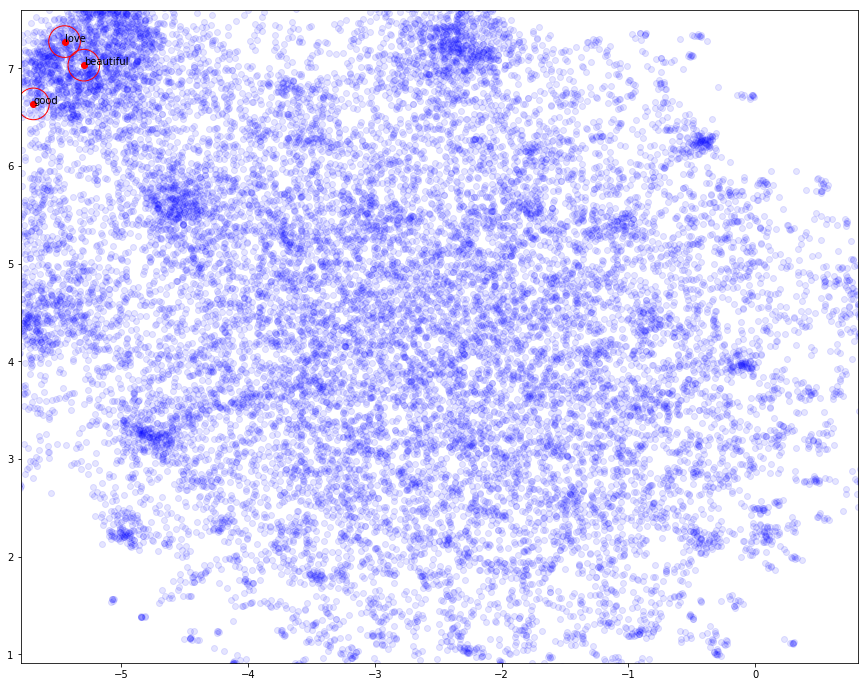

In [23]:
# Feel free to play with word_annotations argument!
# Check the saved dictionary!
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'tsne': reduce_tSNE,
        'umap': reduce_umap
    }
    
    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')
    
    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)
        

# SVD
# run_visualization('svd', ['good', 'love', 'beautiful'], word_to_idx, co_occurrence_matrix)

# t-SNE
# run_visualization('tsne', ['good', 'love', 'beautiful'], word_to_idx, co_occurrence_matrix)

# UMAP
run_visualization('umap', ['good', 'love', 'beautiful'], word_to_idx, co_occurrence_matrix)

plt.show()

### 2.4 Embedding properties

Visualization can give us a rough idea of how word embeddings are organized and if some semantic properties are reflected in the numerical dimensional space. <br>
$\rightarrow$ For example, are synonyms close together? Ideally, if the dataset is big enough, we should see similar vector embeddings since synonyms usually have similar contexts.

##### How to do that?
We could highlight target words in the visualization step and check if our expectations are met. For instance, synonyms should be close together. <br>

**However**, this method is rather **inaccurate** and **time-consuming** (dimensionality reduction is not a perfect mapping). <br>
$\rightarrow$ We need some sort of similarity metric that is independent of the vector dimensionality.

### 2.5 Cosine Similarity

We want to measure how two word vectors are far apart.

#### Naive Method

A naive solution would involve computing the dot product of the two vectors. However, this metric will give higher similarity either to longer vectors or to vectors that have higher counts.

#### Cosine Similarity

A better metric is **cosine similarity** which is just a normalized dot product.

\begin{align}
s(p, q) = \frac{p \, \cdot \, q}{||p|| \, \cdot \, ||q||}
\end{align}

where $s(p, q) \in [-1, 1] $, since it computes the cosine of the angle between the two vectors. 

Intuitively, we are bringing vectors down to the d-dimensional unit sphere (d is the vocab size) and then computing their distance (in 2D space we will have a circle).

In [56]:
from sklearn.metrics.pairwise import cosine_similarity as sk_cs

def cosine_similarity(p: np.ndarray,
                      q: np.ndarray,
                      transpose_p: bool = False,
                      transpose_q: bool = False) -> np.ndarray:
    """
    Computes the cosine similarity of two d-dimensional matrices

    :param p: d-dimensional vector (np.ndarray) of shape (p_samples, d)
    :param q: d-dimensional vector (np.ndarray) of shape (q_samples, d)
    :param transpose_p: whether to transpose p or not
    :param transpose_q: whether to transpose q or not

    :return
        - cosine similarity matrix S of shape (p_samples, q_samples)
          where S[i, j] = s(p[i], q[j])
    """
    if len(p.shape) == 1:
        p = p.reshape(1, -1)
    if len(q.shape) == 1:
        q = q.reshape(1, -1)

    return sk_cs(p, q)

similarity_matrix = cosine_similarity(co_occurrence_matrix,
                                      co_occurrence_matrix,
                                      transpose_q=True)

### 2.6 [Let's play] Analogies, Bias, Synonyms and Antonyms

Let's look for some words and provide a possible explanation of achieved results according to cosine similarity metric.

* Synonym pair: (w1, w2) such that w1 and w2 are synonyms
* Antonyms pair: (w1, w2) such that w1 and w2 are antonyms
* Synonym-Antonym triplet: (w1, w2, w3) such that w1 and w2 are synonyms and w1 and w3 are antonyms

#### Analogy

Another useful property to check is analogy resolution via word vectors. 

In particular, we might want to check if analogies such "man : king == woman : x" bring results like "x = queen".

In order to do so, we first need to define a ranking function that returns the top $K$ most similar words of a given word vector. <br>
$\rightarrow$ We might not want to be too much restrictive and play with $K \ge 1$.

In [25]:
from itertools import product

def show_similarity_for_nary(words: List[str],
                             similarity_matrix: np.ndarray,
                             word_to_idx: Dict[str, int],
                             idx_to_word: Dict[int, str]):
    """
    Shows similarity values for each pair of input words.

    :param words: a list of candidate words.
    :param similarity_matrix: np.ndarray containing similarity values 
    between each vocabulary word pair
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    """
    word_indexes = [word_to_idx[word] for word in words]
    similarity_dict = {}

    for comb in product(word_indexes, word_indexes):
        similarity_value = similarity_matrix[comb[0], comb[1]]
        similarity_dict.setdefault(comb[0], []).append(similarity_value)

    similarity_df = pd.DataFrame.from_dict(similarity_dict)
    similarity_df.columns = [idx_to_word[col] for col in similarity_df.columns]
    similarity_df.index = similarity_df.columns
    similarity_df = similarity_df.transpose()
    print(F'Similarity values: \n{similarity_df}')

show_similarity_for_nary(['film', 'movie'], similarity_matrix, word_to_idx, idx_to_word)
show_similarity_for_nary(['good', 'bad'], similarity_matrix, word_to_idx, idx_to_word)
show_similarity_for_nary(['good', 'well', 'bad'], similarity_matrix, word_to_idx, idx_to_word)

Similarity values: 
           film     movie
film   1.000001  0.880488
movie  0.880488  1.000001
Similarity values: 
          good       bad
good  0.999999  0.848353
bad   0.848353  0.999999
Similarity values: 
          good      well       bad
good  0.999999  0.814306  0.848353
well  0.814306  1.000000  0.749473
bad   0.848353  0.749473  0.999999


In [57]:
def get_top_K_indexes(data: np.ndarray, K: int) -> np.ndarray:
    """
    Returns the top K indexes of a 1-dimensional array (descending order)
    Example:
        data = [0, 7, 2, 1]
        best_indexes:
        K = 1 -> [1] (data[1] = 7)
        K = 2 -> [1, 2]
        K = 3 -> [1, 2, 3]
        K = 4 -> [1, 2, 3, 4]

    :param data: 1-d dimensional array
    :param K: number of highest value elements to consider

    :return
        - array of indexes corresponding to elements of highest value
    """
    best_indexes = np.argsort(data, axis=0)[::-1]
    best_indexes = best_indexes[:K]

    return best_indexes

In [58]:
def get_top_K_word_ranking(embedding_matrix: np.ndarray, idx_to_word: Dict[int, str],
                           word_to_idx: Dict[str, int],  positive_listing: List[str],
                           negative_listing: List[str],  K: int) -> (List[str], np.ndarray):
    """
    Finds the top K most similar words following this reasoning:
        1. words that have highest similarity to words in positive_listing
        2. words that have highest distance to words in negative_listing
        
    :param embedding_matrix: embedding matrix of shape (words, embedding dimension).
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param positive_listing: list of words that should have high similarity with top K retrieved ones.
    :param negative_listing: list of words that should have high distance to top K retrieved ones.
    :param K: number of best word matches to consider

    :return
        - top K word matches according to aforementioned criterium
        - similarity values of top K word matches according to aforementioned criterium
    """
    # Positive words (similarity)
    positive_indexes = np.array([word_to_idx[word] for word in positive_listing])
    word_positive_vector = np.sum(embedding_matrix[positive_indexes, :], axis=0)

    # Negative words (distance)
    negative_indexes = np.array([word_to_idx[word] for word in negative_listing])
    word_negative_vector = np.sum(embedding_matrix[negative_indexes, :], axis=0)

    # Find candidate words
    target_vector = (word_positive_vector - word_negative_vector) / (len(positive_listing) + len(negative_listing))
    total_indexes = np.concatenate((positive_indexes, negative_indexes))
    valid_indexes = np.setdiff1d(np.arange(similarity_matrix.shape[0]), total_indexes)
    candidate_vectors = embedding_matrix[valid_indexes]

    candidate_similarities = cosine_similarity(candidate_vectors, target_vector, transpose_q=True)
    candidate_similarities = candidate_similarities.ravel()

    relative_indexes = get_top_K_indexes(candidate_similarities, K)
    top_K_indexes = valid_indexes[relative_indexes]
    top_K_words = [idx_to_word[idx] for idx in top_K_indexes]

    return top_K_words, candidate_similarities[relative_indexes]

In [29]:
"""
    Positive and negative listing can be defined accordingly to a given analogy
    Example:
        
        man : king :: woman : x
    
    positive_listing = ['king', 'woman']
    negative_listing = ['man']

    This is equivalent to: compute king - man + woman, and then find the
    most similar candidate.
"""

# Examples
# tv : episodes :: film : x
# masterpiece : superb :: x : tragic
top_K_words, top_K_values = get_top_K_word_ranking(embedding_matrix=co_occurrence_matrix,
                                                   idx_to_word=idx_to_word,
                                                   word_to_idx=word_to_idx,
                                                   positive_listing=['episodes', 'film'],
                                                   negative_listing=['tv'],
                                                   K=10)
print(f'Top K words: {top_K_words}')
print(f'Top K values: {top_K_values}')

Top K words: ['movie', 'one', 'could', 'really', 'well', 'get', 'people', 'would', 'much', 'time']
Top K values: [0.8695329  0.81243765 0.7748887  0.77313286 0.7701006  0.7648783
 0.76240325 0.7612888  0.7600143  0.75984687]


# PART II

*   Loading pre-trained **dense** word embeddings: Word2Vec, GloVe, FastText.
*   Checking **out-of-vocabulary** (OOV) terms.
*   **Handling** OOV terms.

## 1. Dense embeddings

Until now we've worked with sparse embedding methods, which lead to high dimensional word embeddings (dimension equal to $|V|$). 

The **main drawback** of such approach is that words belong to separate dimensions. <br>
$\rightarrow$ We need to have a large corpus available to check if two words have similar contexts.

#### Dense Embedding Technique

To this end, we might prefer a dense embedding technique. <br>
$\rightarrow$ All words are encoded into a high dimensional space, much smaller than $|V|$ (generally up to $\sim 1000$).

A dense representation is also convenient from a machine learning point of view:
*    **Fewer parameters** to learn and, thus, models are less prone to overfitting.
*    Words do not belong to separate dimensions anymore and semantic relationships are easily modelled.

In this section, we experiment with pre-trained dense embedding models and compare them to previously described sparse methods.

### 1.1 Working with a pre-trained model

The first step consists in choosing and downloading a pre-trained embedding model. 

For the purpose of this assignment, we limit to classic models, such as Word2Vec, GloVe and FastText.

Furthermore, some pre-trained embedding model versions may be quite resource demanding, depending on the embedding dimension and on the vocabulary size. <br>
$\rightarrow$ We recommend sticking to low dimensional spaces (50, 100, 200) to avoid being stuck waiting for too much time.

### A Brief Recap

* **Word2Vec**: the first example of dense word encoding. There are two well-known strategies:
     * Continuous Bag-of-words (CBoW): context words are used to predict a target word.
     * Skip-gram: a target word is used to predict its own context.
* **GloVe**: it is another techniques that tries to encoded global semantic properties based on the co-occurrence matrix. Conversely, word2vec exploits local information.
* **Fasttext**: an extension of word2vec where words are defined as character n-grams. It works very well with rare words contrarily to Word2Vec and GloVe.

For a full list of available embeddings models, please check [here](https://github.com/RaRe-Technologies/gensim-data).

In [59]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [31]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300 
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=50)

### 1.2 Out of vocabulary (OOV) words

Before evaluating pre-trained dense word embeddings, it is good practice to check if the model is consistent with our dataset. <br> 
$\rightarrow$ We check the number of out-of-vocabulary (OOV) terms.

If the OOV amount is negligible, we can just keep going. On the other hand, we might want to handle OOV terms by assigning them a specific word vector.

**Which one?** One common practice is to assign a **random vector**, since the embedding model will be part of a deep learning model and, thus, word vectors might be trained during the learning process. 

Even if that is the case, we can assign an embedding that is more meaningful rather than a random one. <br>
$\rightarrow$ We can identify the word embedding of an OOV term as the **mean of its neighbour word embeddings**.

In [60]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [33]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 2372 (12.39%)


### 1.3 Handling OOV words

Now we proceed on building the embedding matrix, while handling OOV terms at the same time. 

In [61]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [35]:
# Testing
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, len(word_to_idx), oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 19139/19139 [00:00<00:00, 393507.70it/s]

Embedding matrix shape: (19139, 50)


### 1.4 Embedding visualization (cont'd)

We are now ready to visualize pre-trained word embeddings!

Running UMAP reduction method... (it may take a while...)
UMAP reduction completed!
Annotating words: ['good', 'love', 'beautiful']


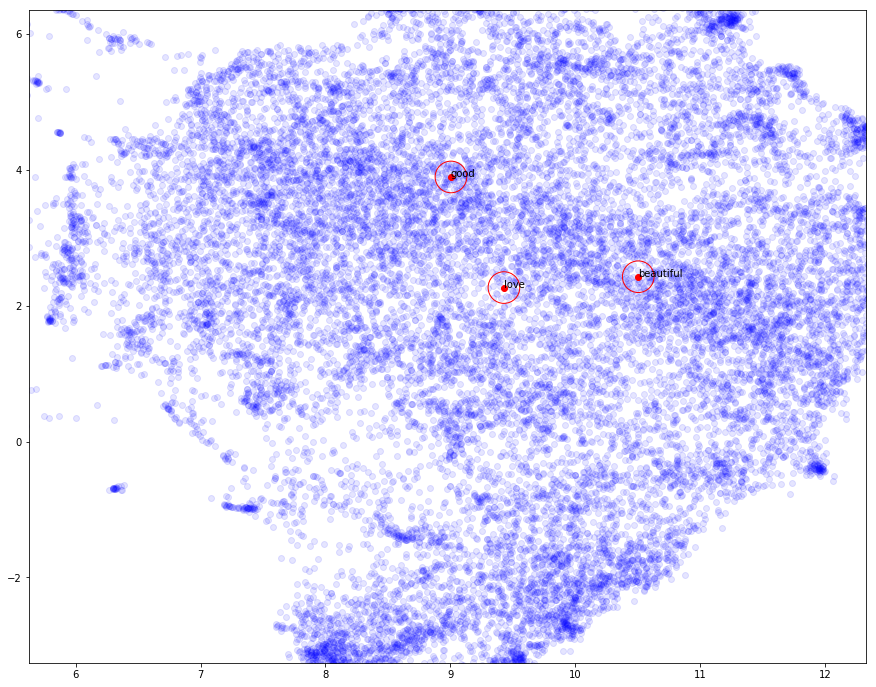

In [36]:
# UMAP
reduced_embedding_umap = reduce_umap(embedding_matrix)
visualize_embeddings(reduced_embedding_umap, ['good', 'love', 'beautiful'], word_to_idx)
plt.show()

### 1.5 [Let's play!] Embedding properties (cont'd)

Let's consider some previous examples for quick comparison.

In [37]:
top_K_words, top_K_values = get_top_K_word_ranking(embedding_matrix=embedding_matrix,
                                                   idx_to_word=idx_to_word,
                                                   word_to_idx=word_to_idx,
                                                   positive_listing=['episodes', 'film'],
                                                   negative_listing=['tv'],
                                                   K=10)
print(f'Top K words: {top_K_words}')
print(f'Top K values: {top_K_values}')

Top K words: ['adaptation', 'episode', 'novel', 'films', 'sequel', 'novels', 'screenplay', 'soundtrack', 'cameo', 'drama']
Top K values: [0.78791964 0.7871996  0.7586306  0.74662924 0.73375267 0.732013
 0.7301122  0.72881854 0.708628   0.69585866]


# PART III
*   Problem setting: **sentiment analysis task**.
*   Setting up a **data pipeline**: from dataset loading to data conversion.
*   **Model definition** (with Keras framework).
*   Model training, inference and **evaluation**.

## 1. Problem setting

In the second part of this tutorial, we'll tackle the same sentiment analysis task of Tutorial 1. <br>
$\rightarrow$ However, we'll consider simple neural network models as baselines.

In particular, we'll briefly introduce:
* How to properly **train** and **evaluate** neural networks.
* Introduce some **regularization techniques** to avoid unwanted scenarios like model overfitting.
* Good practices for **proper** experimental setup definition.


### 1.1 Task formulation

As in Tutorial 1, we consider the classification task of predicting the sentiment of a given sentence. 

More precisely, we consider the binary classification problem where the sentiment label can either be $positive$ or $negative$.

Formally, we denote:

Input sentence --> $x$

Sentiment label --> $y \in [positive, negative]$

### 1.2 Neural Framework

We'll use [Keras](https://keras.io/), a high-level deep learning framework that is compatible with multiple backend libraries, such as [Tensorflow](https://www.tensorflow.org/) and [Theano](https://github.com/Theano/Theano).

As the backend, we will consider Tensorflow as one of the most popular deep learning libraries.

Feel free to experiment with other popular frameworks like [Pytorch](https://pytorch.org/). <br>
$\rightarrow$ Some flexibility is always considered a bonus since some models might be available for only one particular framework.

## 2. Data pipeline

As outlined in the first tutorial, we need to define a proper pipeline to convert initial textual input into a numerical format that is compatible with our models.

This pipeline is usually summarized as follows:

*   Dataset loading
*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation

In this tutorial, we'll propose our solution by following above schema.

### 2.1 Data Loading

First of all, we need to load our dataset. 

Contrarily to Part I, we go beyond dataset limitations and consider the whole dataset.

In [63]:
print("Encoding dataset...")
df = encode_dataset("aclImdb")
print("Encoding completed!")

  0%|          | 0/2 [00:00<?, ?it/s]

Encoding dataset...


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Encoding completed!


### 2.2 Data Pre-processing

For the task of sentiment analysis, we've already defined the I/O of the model. However, each input sentence is viewed as a sequence of tokens.

We've already introduced a simple text cleaning implementation (see Section 1.4). Thus, we quickly re-apply the text cleaning to our textual data as follows.

In [64]:
df['text'] = df['text'].apply(lambda txt: text_prepare(txt))

### 2.3 Data Splitting

We distinguish between train, validation and test splits.

In particular, we define a validation set that helps us evaluating our model during the training routine and avoiding overfitting.

Since the dataset is balanced we apply a random split as follows.

In [73]:
from sklearn.model_selection import train_test_split

train_data = df[df['split'] == 'train']
test_data = df[df['split'] == 'test']

x_train = train_data['text'].values
y_train = train_data['sentiment'].values

x_test = test_data['text'].values
y_test = test_data['sentiment'].values

# Random split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  train_size=0.80,
                                                  test_size=0.20,
                                                  random_state=42)

print('Dataset splits statistics: ')
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Dataset splits statistics: 
Train data: (20000,)
Validation data: (5000,)
Test data: (25000,)


For tokenization, we have already defined a vocabulary, but we prefer to introduce a more efficient tool that Keras offers: the [Keras Tokenizer]((https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

For simplicity, we define a simple high-level wrapper that comes in handy for what we have to do.

**Note**: this tokenizer also supports pre-trained embedding models. In this case, an embedding matrix is built to directly initialize the embedding layer of our model.

In [74]:
import tensorflow as tf


class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int
        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = None
        self.embedding_matrix = None
        self.vocab = None
        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)
        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')
        self.vocab = self.tokenizer.word_index
        if self.build_embedding_matrix:
            print('Loading embedding model! It may take a while...')
            self.embedding_model = load_embedding_model(model_type=self.embedding_model_type,
                                                        embedding_dimension=self.embedding_dimension)
            
            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=list(self.vocab.keys()))

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab) + 1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms)
            print('Done!')


    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

### Note
Normally, we would make use of pre-trained word embeddings for all our dataset. 

However, the pre-trained embedding matrix might be huge, occupying a lot of memory. 

A good approach consists in determining the amount of used tokens in order to reduce the size of the embedding matrix. <br>
$\rightarrow$ Usually, it is also fairly acceptable to just consider tokens that are in the train set for simplicity.

In [75]:
tokenizer_args = {
    'oov_token': 'UNK',
}
embedding_dimension = 50
tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           build_embedding_matrix=True,
                           embedding_dimension=embedding_dimension,
                           embedding_model_type="glove")
tokenizer.build_vocab(x_train)
tokenizer_info = tokenizer.get_info()
print(f'Tokenizer info: {tokenizer_info}')

Fitting tokenizer...
Fit completed!
Loading embedding model! It may take a while...


 46%|████▌     | 42846/92667 [00:00<00:00, 428444.06it/s]

Checking OOV terms...
Building the embedding matrix...


100%|██████████| 92667/92667 [00:00<00:00, 322311.02it/s]

Done!
Tokenizer info: {'build_embedding_matrix': True, 'embedding_dimension': 50, 'embedding_model_type': 'glove', 'embedding_matrix': (92668, 50), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f7bcb7fdda0>, 'vocab_size': 92668}


### 2.4 Data Conversion

We are ready to convert input data into numerical format.

#### Labels

Note that, we have also to convert labels into numerical format, since the neural network baselines will be trained to minimize an objective function that is based on input labels. However, in this example, labels are already in numerical format.

#### Padding

Since neural networks are trained with data mini-batches, we need to make sure that each of our inputs are of the same size in order to store them into **rectangular matrices**. This process is usually referred to as **padding** and its applicability really depends on how you define mini-batches.

For instance, you might want to pad each mini-batch **individually**, pad **all of them** to the same size or **not apply pad at all**! In the latter case, it is mandatory to define mini-batches with samples of the same length. This process is usually a bit slower but saves a lot of memory.

Padding has also the **drawback of potential data truncation**. Usually, we can determine the padding size in order to handle the majority of our data (95-99%).
The are always outliers that might over-estimate the padding size and lead to high memory usage!

For the purpose of this tutorial, we apply a simple global padding based on the
training data.

In [76]:
def convert_text(texts, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """
    text_ids = tokenizer.convert_tokens_to_ids(texts)

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

In [77]:
# Train
x_train, max_seq_length = convert_text(texts=x_train, tokenizer=tokenizer, is_training=True)
print(f"Max token sequence: {max_seq_length}")
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')

# Val
x_val = convert_text(texts=x_val, tokenizer=tokenizer, is_training=False, max_seq_length=max_seq_length)

print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')

# Test
x_test = convert_text(texts=x_test, tokenizer=tokenizer, is_training=False, max_seq_length=max_seq_length)

print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

Max token sequence: 471
X train shape: (20000, 471)
Y train shape: (20000,)
X val shape: (5000, 471)
Y val shape: (5000,)
X test shape: (25000, 471) (25000, 471)
Y test shape: (25000,) (25000,)


### 2.5 Model Definition

Keras offers a simple and high-level interface for model definition. <br>
$\rightarrow$ This allows you to define simple models in very few line of codes.

There are several ways of defining a Keras model. 

For the purpose of this tutorial, we'll define our model using the [Keras Sequential APIs](https://keras.io/guides/sequential_model/).

Our model will be a simple MLP. We won't explore advanced architectures like RNNs and CNNs. However, feel free to try them out as exercise!

In [78]:
from tensorflow import keras
from tensorflow.keras import layers


def create_model(layers_info: List[Dict], compile_info: Dict) -> keras.Model:
    """
    Create a Keras model given a list of layer information

    :param layers_info: a list of dictionaries, one for each layer
    :param compile_info: dictionary containing compile information

    :return
        model: the built keras sequential model
    """
    model = keras.Sequential()
    for info_idx, info in enumerate(layers_info):
        # Make sure the last layer has softmax activation and has 2 units for correct learning.
        if info_idx == len(layers_info) - 1:
            assert info['activation'] == 'softmax'
            assert info['units'] == 2

        layer = info['layer'](**{key: value for key, value in info.items() if key != 'layer'})
        model.add(layer)

    model.summary()
    model.compile(**compile_info)
    return model


class AvgSentenceEmbedding(layers.Layer):

    def call(self, inputs, mask=None, training=False, **kwargs): 
        float_mask = tf.cast(mask, inputs.dtype)
        masked_inputs = inputs * float_mask[:, :, None]
        return tf.reduce_sum(masked_inputs, axis=1) / tf.reduce_sum(float_mask, axis=1)[:, None]

In [79]:
layers_info = [
    {
        "layer": layers.Embedding,
        "output_dim": 50,
        "input_dim": tokenizer_info['vocab_size'],
        "input_length": max_seq_length,
        "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
        "mask_zero": True,
        "name": "embedding_layer"
    },
    {
        "layer": AvgSentenceEmbedding,
        "name": "sentence_embedding"
    },
    {
        'layer': layers.Dense,
        "units": 256,
        "activation": "relu",
        "name": "dense_1"
    },
    {
        "layer": layers.Dense,
        "units": 64,
        "activation": "relu",
        "name": "dense_2"
    },
    {
        "layer": layers.Dense,
        "units": 2,
        "activation": "softmax",
        "name": "logits"
    }
]

In [80]:
compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': [keras.metrics.SparseCategoricalAccuracy()],
}
model = create_model(layers_info, compile_info)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 471, 50)           4633400   
_________________________________________________________________
sentence_embedding (AvgSente (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
logits (Dense)               (None, 2)                 130       
Total params: 4,663,034
Trainable params: 4,663,034
Non-trainable params: 0
_________________________________________________________________


#### Embedding Layer

The embedding layer is the backbone of any NLP neural network architecture. It essentially associates a token index to its corresponding trainable embedding vector.

In the above example, we are defining:

* `output_dim`: the dimension of the embedding vector
* `input_dim`: the size of the vocabulary
* `input_length`: the expected input tokens sequence length
* `weights`: we can initialize the embedding matrix (token indices -> embeddings) with our pre-trained embedding model
* `mask_zero`: Keras automatically ignores `PAD` tokens (token index equal to $0$). This mask is propagated to subsequent layers up to the objective function. This is particularly important for sequence tagging. If enabled with RNNs, make sure you apply a POST padding (as in our example).

#### Sentence Embedding

Intuitively, we need to classify the entire sentence as either positive or negative. However, our input is a sequence of tokens.

One very simple way consists in obtaining the sentence embedding is the mean of its constituting token embeddings. There are other several ways to achieve the same result with much higher quality!

In this example, we make use of the Keras Lambda layer to define input sentence embeddings.

### 2.6 Training and Inference Setup

At this point, we can start training and evaluating our model.

Just like before, Keras offers simple high-level APIs for this step as well.

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
import random

def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [82]:
def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return model

In [83]:
def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: Dict) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [84]:
def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """
    assert len(metrics) == len(metric_names)
    print(f"Evaluating predictions! Total samples: {y.shape[0]}")

    metric_info = {}
    for metric, metric_name in zip(metrics, metric_names):
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info

Start training! 
Parameters: {'verbose': 1, 'epochs': 3, 'batch_size': 64}
Epoch 1/3
313/313 [==============================] - 9s 28ms/step - loss: 0.4641 - sparse_categorical_accuracy: 0.7791 - val_loss: 0.4266 - val_sparse_categorical_accuracy: 0.8034
Epoch 2/3
313/313 [==============================] - 8s 27ms/step - loss: 0.2662 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.3122 - val_sparse_categorical_accuracy: 0.8738
Epoch 3/3
313/313 [==============================] - 9s 27ms/step - loss: 0.1591 - sparse_categorical_accuracy: 0.9416 - val_loss: 0.3096 - val_sparse_categorical_accuracy: 0.8798
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


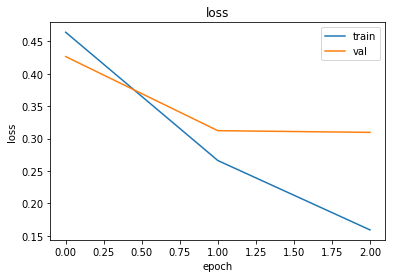

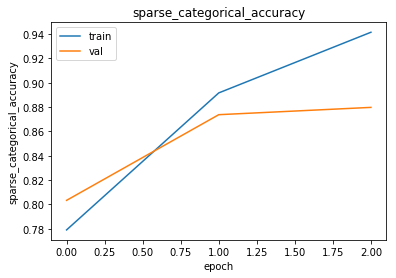

In [85]:
# Training
training_info = {
    'verbose': 1,
    'epochs': 3,
    'batch_size': 64,
}
model = train_model(model=model, x_train=x_train, y_train=y_train,
                    x_val=x_val, y_val=y_val, training_info=training_info)

In [86]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions = predict_data(model=model, x=x_test,
                                      prediction_info=prediction_info)
test_predictions = np.argmax(test_predictions, axis=-1)

# Evaluation
metrics = [
    accuracy_score,
    partial(f1_score, pos_label=1, average='binary')
]
metric_names = [
    "accuracy",
    "binary_f1"
]
metric_info = evaluate_predictions(predictions=test_predictions,
                                   y=y_test,
                                   metrics=metrics,
                                   metric_names=metric_names)
print(f'Metrics info: \n{metric_info}')

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 25000 samples
391/391 [==============================] - 1s 2ms/step
Evaluating predictions! Total samples: 25000
Metrics info: 
{'accuracy': 0.8668, 'binary_f1': 0.8619288498217099}


# PART IV

*   **Regularization** techniques: L2, Dropout, Early Stopping.
*   **Good practices** for experimenting.
*   Intro to **transformers**.

## 1. Regularization Techniques

A curious reader might be wondering how to correctly train a neural network.

#### Learning Curves

One of the best indicators is the learning curve plot, where loss information of train and val splits is shown.

#### Overfitting

If the model quickly overfits, we might need to apply some significant regularization technique. 

Overfit can happen for a lot of different reasons, but it is usually mainly attributed to some biases in the data or to the high representational capacity of the model. In the latter case, we might want to "simplify" our architecture.

#### Underfitting

On the other hand, if the model strongly underfits, we should increase its capacity. This is usually done by increasing the model depth, i.e. by adding some additional layers.

In this section, we'll briefly outline some well-known regularization techniques and show you how to implement them. Remember that model regularization is a technique to reduce the generalization error without reducing the optimization error.

We leave further experiments as exercise. Feel free to try out different combinations of regularization techniques.

### 1.1 Early Stopping

Early stopping is a widely applied regularization technique to avoid model overfitting on the train data.

#### "How many epochs/steps should I train my model?"

A good answer can be informally defined as "Until your model starts performing worse on the validation set".

That's basically what Early Stopping does. Intuitively, we stop the learning process after the model has stopped improving on a certain validation metric.

#### Which validation metric?

Which one? The best practice goes for the validation loss, however, in challenging scenarios with unbalanced data, you might want to achieve the best possible model performance. More generally, you might want to track multiple metrics at the same time!

Here is some useful reading material regarding Early Stopping:

* [Deep learning book, section 7.8](https://www.deeplearningbook.org/contents/regularization.html)
* [Multiple metrics Early Stopping](http://alexadam.ca/ml/2018/08/03/early-stopping.html)
* [Early Stopping blog](https://towardsdatascience.com/the-million-dollar-question-when-to-stop-training-deep-learning-models-fa9b488ac04d)

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': 20,
    'batch_size': 64,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=5,
                                                restore_best_weights=True)]
}

#### Early Stopping in Keras

Keras defines early stopping via a callback.

The `monitor` argument tells the callback on which metric to enforce early stopping.

The `patience` arguments defines the number of epochs to wait for metric improvement. If more than `patience` epochs occur since last improvement, the training routine is halted.

The `restore_best_weights` argument tells the callback to reload model weights associated to the best performing epoch (w.r.t. monitored metric).

For more details, please check the official [documentation](https://keras.io/api/callbacks/early_stopping/)

### 1.2 L2 or Weight Decay

It is also known as Ridge regression or Tikhonov regularization.

It is the simplest norm penalty regularization:

\begin{align}
\tilde{J}(x, y; \theta) = J(x, y; \theta) + \alpha \Omega(\theta)
\end{align}

where $\Omega(\theta) = \frac{1}{2}||\theta||_2^2$

In simple terms, weight decays rescales weights along eigenvectors directions (of the Hessian matrix, $H$). <br>
Specifically, each eigenvector of $H$ is rescaled by a factor:

\begin{align}
\frac{\lambda_i}{\lambda_i + \alpha}
\end{align}

Along directions where eigenvalues are large, weight decay has little or no effect. On the other hand, components with small eigenvalues will shrink to have nearly zero magnitude. <br>
$\rightarrow$ The objective function on those direction won't change too much (minor curvature).

In Keras, weight decay has to be defined for each layers as follows.

In [ ]:
layers_info = [
    # {...}
    {
        "layer": layers.Dense,
        "units": 128,
        "activation": "relu",
        "kernel_regularizer": keras.regularizers.l2(0.01)
    },
    {
        "layer": layers.Dense,
        "units": 16,
        "activation": "relu",
        "kernel_regularizer": keras.regularizers.l2(0.01)
    },
    {
        "layer": layers.Dense,
        "units": 2,
        "activation": None
    }
]

In this example, the first two Dense layers will have a weight decay with coefficient $\alpha = 0.01$.

A good practice, consists in defining a single $\alpha$ for all layers, but it not mandatory.

### 1.3 Dropout

Dropout originates as a smart solution to overcome the drawback of **bagging**. The idea is to consider sub-networks of the original architectures as an ensemble.

These sub-networks are created by literally 'dropping out' some neurons in the model.

#### Advantage

The additional advantage w.r.t. to bagging is that these sub-networks share their weights. Thus, it is possible to train an exponential number of sub-networks with a tractable amount of memory.

However, the key insight is that dropout forces each hidden unit to perform well regardless of other units in the sub-network. Thus, each unit is regularized to be a good feature in many contexts.

In Keras, dropout takes the form of a layer as follows.

In [ ]:
layers_info = [
    # {...}
    {
        "layer": layers.Dense,
        "units": 128,
        "activation": "relu",
    },
    {
        "layer": layers.Dropout,
        "rate": 0.2
    },
    {
        "units": 16,
        "activation": "relu",
        "kernel_regularizer": keras.regularizers.l2(0.01)
    },
    {
        "layer": layers.Dropout,
        "rate": 0.2
    },
    {
        "units": 2,
        "activation": None
    }
]

In this example, we are adding two additional Dropout layers to our model, both of them with dropout rate set to $0.2$. This means, that there's a $20\%$ chance of dropping input units.

#### Do It Yourself

Have fun experimenting with different combinations of regularization techniques and inspect the achieved learning curves!

## 2. Good Practices

#### Robust Evaluation Routine

Depending on the given setting, you might need to set up a specific evaluation routine:
* Train and Test
* K-fold Cross-Validation
* Leave-one-out

Model evaluation should take into account:
* Corpus size $\rightarrow$ number of samples
* Model variance

#### Reproducibility

Reproducibility is a fundamental evaluation property in order to make **fair evaluation**.
*  Clear and reproducible data pipeline
*  Model training and evaluation with **multiple** and **fixed** seeds

In [87]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [53]:
seeds = [42, 2022, 1500, 1337, 666]
avg_metric_info = {}

for seed in seeds:
    print(f'Running with seed: {seed}')
    set_reproducibility(seed)
    
    model = create_model(layers_info, compile_info) 
    model = train_model(model=model, x_train=x_train, y_train=y_train,
                        x_val=x_val, y_val=y_val, training_info=training_info,
                        show=False)

    test_predictions = predict_data(model=model, x=x_test,
                                          prediction_info=prediction_info)
    test_predictions = np.argmax(test_predictions, axis=-1)

    metric_info = evaluate_predictions(predictions=test_predictions, 
                                       y=y_test,
                                       metrics=metrics,
                                       metric_names=metric_names)
    for key, value in metric_info.items():
        avg_metric_info.setdefault(key, []).append(value)

avg_metric_info = {key: np.mean(value) for key, value in avg_metric_info.items()}
print(f'Metrics info: \n{avg_metric_info}')

Running with seed: 42
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 471, 50)           4633400   
_________________________________________________________________
sentence_embedding (AvgSente (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
logits (Dense)               (None, 2)                 130       
Total params: 4,663,034
Trainable params: 4,663,034
Non-trainable params: 0
_________________________________________________________________
Start training! 
Parameters: {'verbose': 1, 'epochs': 5, 'batch_size': 64}
Epoch 1/5
313

KeyboardInterrupt: 

#### Reproducibility with different backends

I recommend the [framework determinism](https://github.com/NVIDIA/framework-determinism) framework to set up a reproducible enviroment with popular backends like
* Tensorflow
* Pytorch

## 3. Transformers

Defining simple baseline is usually a good starting point to:
* Task benchmarking
* Code testing

However, we know that Transformer-based models are they baseline to go when assessing the challenge of a new task or benchmarking on a novel corpus.

#### Transformers in Keras

We'll rely on well known libraries for defining a simple Transformer-based baseline:
* HuggingFace $\rightarrow$ transformers

In [88]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig, PretrainedConfig

def create_bert_model(compile_info: List[Dict],
                      pretrained_model_name_or_path: str) -> keras.Model:
    """
    Create a Keras model given a list of layer information

    :param layers_info: a list of dictionaries, one for each layer
    :param compile_info: dictionary containing compile information

    :return
        model: the built keras sequential model
    """
    # Load pre-trained model
    bert = TFDistilBertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=pretrained_model_name_or_path,
                                                                 num_labels=2)

    model.summary()
    model.compile(**compile_info)
    return model

In [89]:
pretrained_model_name_or_path = 'distilbert-base-uncased'
compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': 'sparse_categorical_crossentropy',
    'metrics': [keras.metrics.SparseCategoricalAccuracy()],
}
# Training
training_info = {
    'verbose': 1,
    'epochs': 2,
    'batch_size': 16,
}
# Inference
prediction_info = {
    'batch_size': 16,
    'verbose': 1
}
model = create_bert_model(compile_info=compile_info,
                          pretrained_model_name_or_path=pretrained_model_name_or_path)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 471, 50)           4633400   
_________________________________________________________________
sentence_embedding (AvgSente (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
logits (Dense)               (None, 2)                 130       
Total params: 4,663,034
Trainable params: 4,663,034
Non-trainable params: 0
_________________________________________________________________


In [90]:
seeds = [42]
avg_metric_info = {}

for seed in seeds:
    print(f'Running with seed: {seed}')
    set_reproducibility(seed)
    
    model = create_bert_model(compile_info=compile_info,
                          pretrained_model_name_or_path=pretrained_model_name_or_path)
    model = train_model(model=model, x_train=x_train, y_train=y_train,
                        x_val=x_val, y_val=y_val, training_info=training_info,
                        show=False)

    test_predictions = predict_data(model=model, x=x_test,
                                          prediction_info=prediction_info)
    test_predictions = np.argmax(test_predictions, axis=-1)

    metric_info = evaluate_predictions(predictions=test_predictions,
                                       y=y_test,
                                       metrics=metrics,
                                       metric_names=metric_names)
    for key, value in metric_info.items():
        avg_metric_info.setdefault(key, []).append(value)

avg_metric_info = {key: np.mean(value) for key, value in avg_metric_info.items()}
print(f'Metrics info: \n{avg_metric_info}')

Running with seed: 42


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 471, 50)           4633400   
_________________________________________________________________
sentence_embedding (AvgSente (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
logits (Dense)               (None, 2)                 130       
Total params: 4,663,034
Trainable params: 4,663,034
Non-trainable params: 0
_________________________________________________________________
Start training! 
Parameters: {'verbose': 1, 'epochs': 2, 'batch_size': 16}
Epoch 1/2
1250/1250 [================

# Takeaway Messages

#### Teaching 

Your TA should be quite thirsty and tired at this point, make sure they are okay even though you didn't understand a single word of their "English". Possibly, offer them a beer 💞.

#### Dense vs Sparse Embeddings

Dense word embeddings are very cool w.r.t. to sparse ones. However, we've just explored fixed embedding models: each word has its own embedding vector independently of the current context.

#### Out-of-vocabulary Terms
OOV terms are everywhere, when we should worry about them? Have a look at pre-trained embedding models if they are suitable to your domain to drastically reduce this issue.

#### Data Pipeline

Think about the whole data pipeline! Investigate your data before any experiment and start with simple baselines. You have to understand the setting before anything else.

#### Regularization
Depending on the given scenario and related experimental results, you might want to consider regularization techniques to achieve better generalization performance.

#### Robust and Reproducible Experiments

Define consistent and reproducible experiments for fair model comparison $\rightarrow$ control training and evaluation stochasticity.

#### Transformers

Transformers models are everywhere and are the way-to-go baseline. There exist several libraries for quick experimenting.

# The End!